# Final Project - Prototype

In [16]:
import cv2
import fitz # This is actually PyMuPDF
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import re
import torch

from IPython.display import Image, display
from PIL import Image
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection

## Load Page Image

In [17]:
# Specify financial statement filename
# statement_filename, page_index = "../statements/407 International - March 31 2021.pdf", 1
statement_filename, page_index = "../statements/Air Canada - December 31 2019.pdf", 6
# statement_filename, page_index = "../statements/BCE - Financial Report - 2020-2022.pdf", 82
# statement_filename, page_index = "../statements/Better Life Pharama Inc - Jan 31 Oct 31 2022.pdf", 2
# statement_filename, page_index = "../statements/Rogers - Q1-2020.pdf", 3
# statement_filename, page_index = "../statements/Starbucks - Annual Report - 2020.pdf", 53

# Convert PDF page to image
statement_pages = []
statement_doc = fitz.open(statement_filename)
statement_page = statement_doc[page_index].get_pixmap(dpi=250)

Image dimensions: 2125 x 2750 x 3


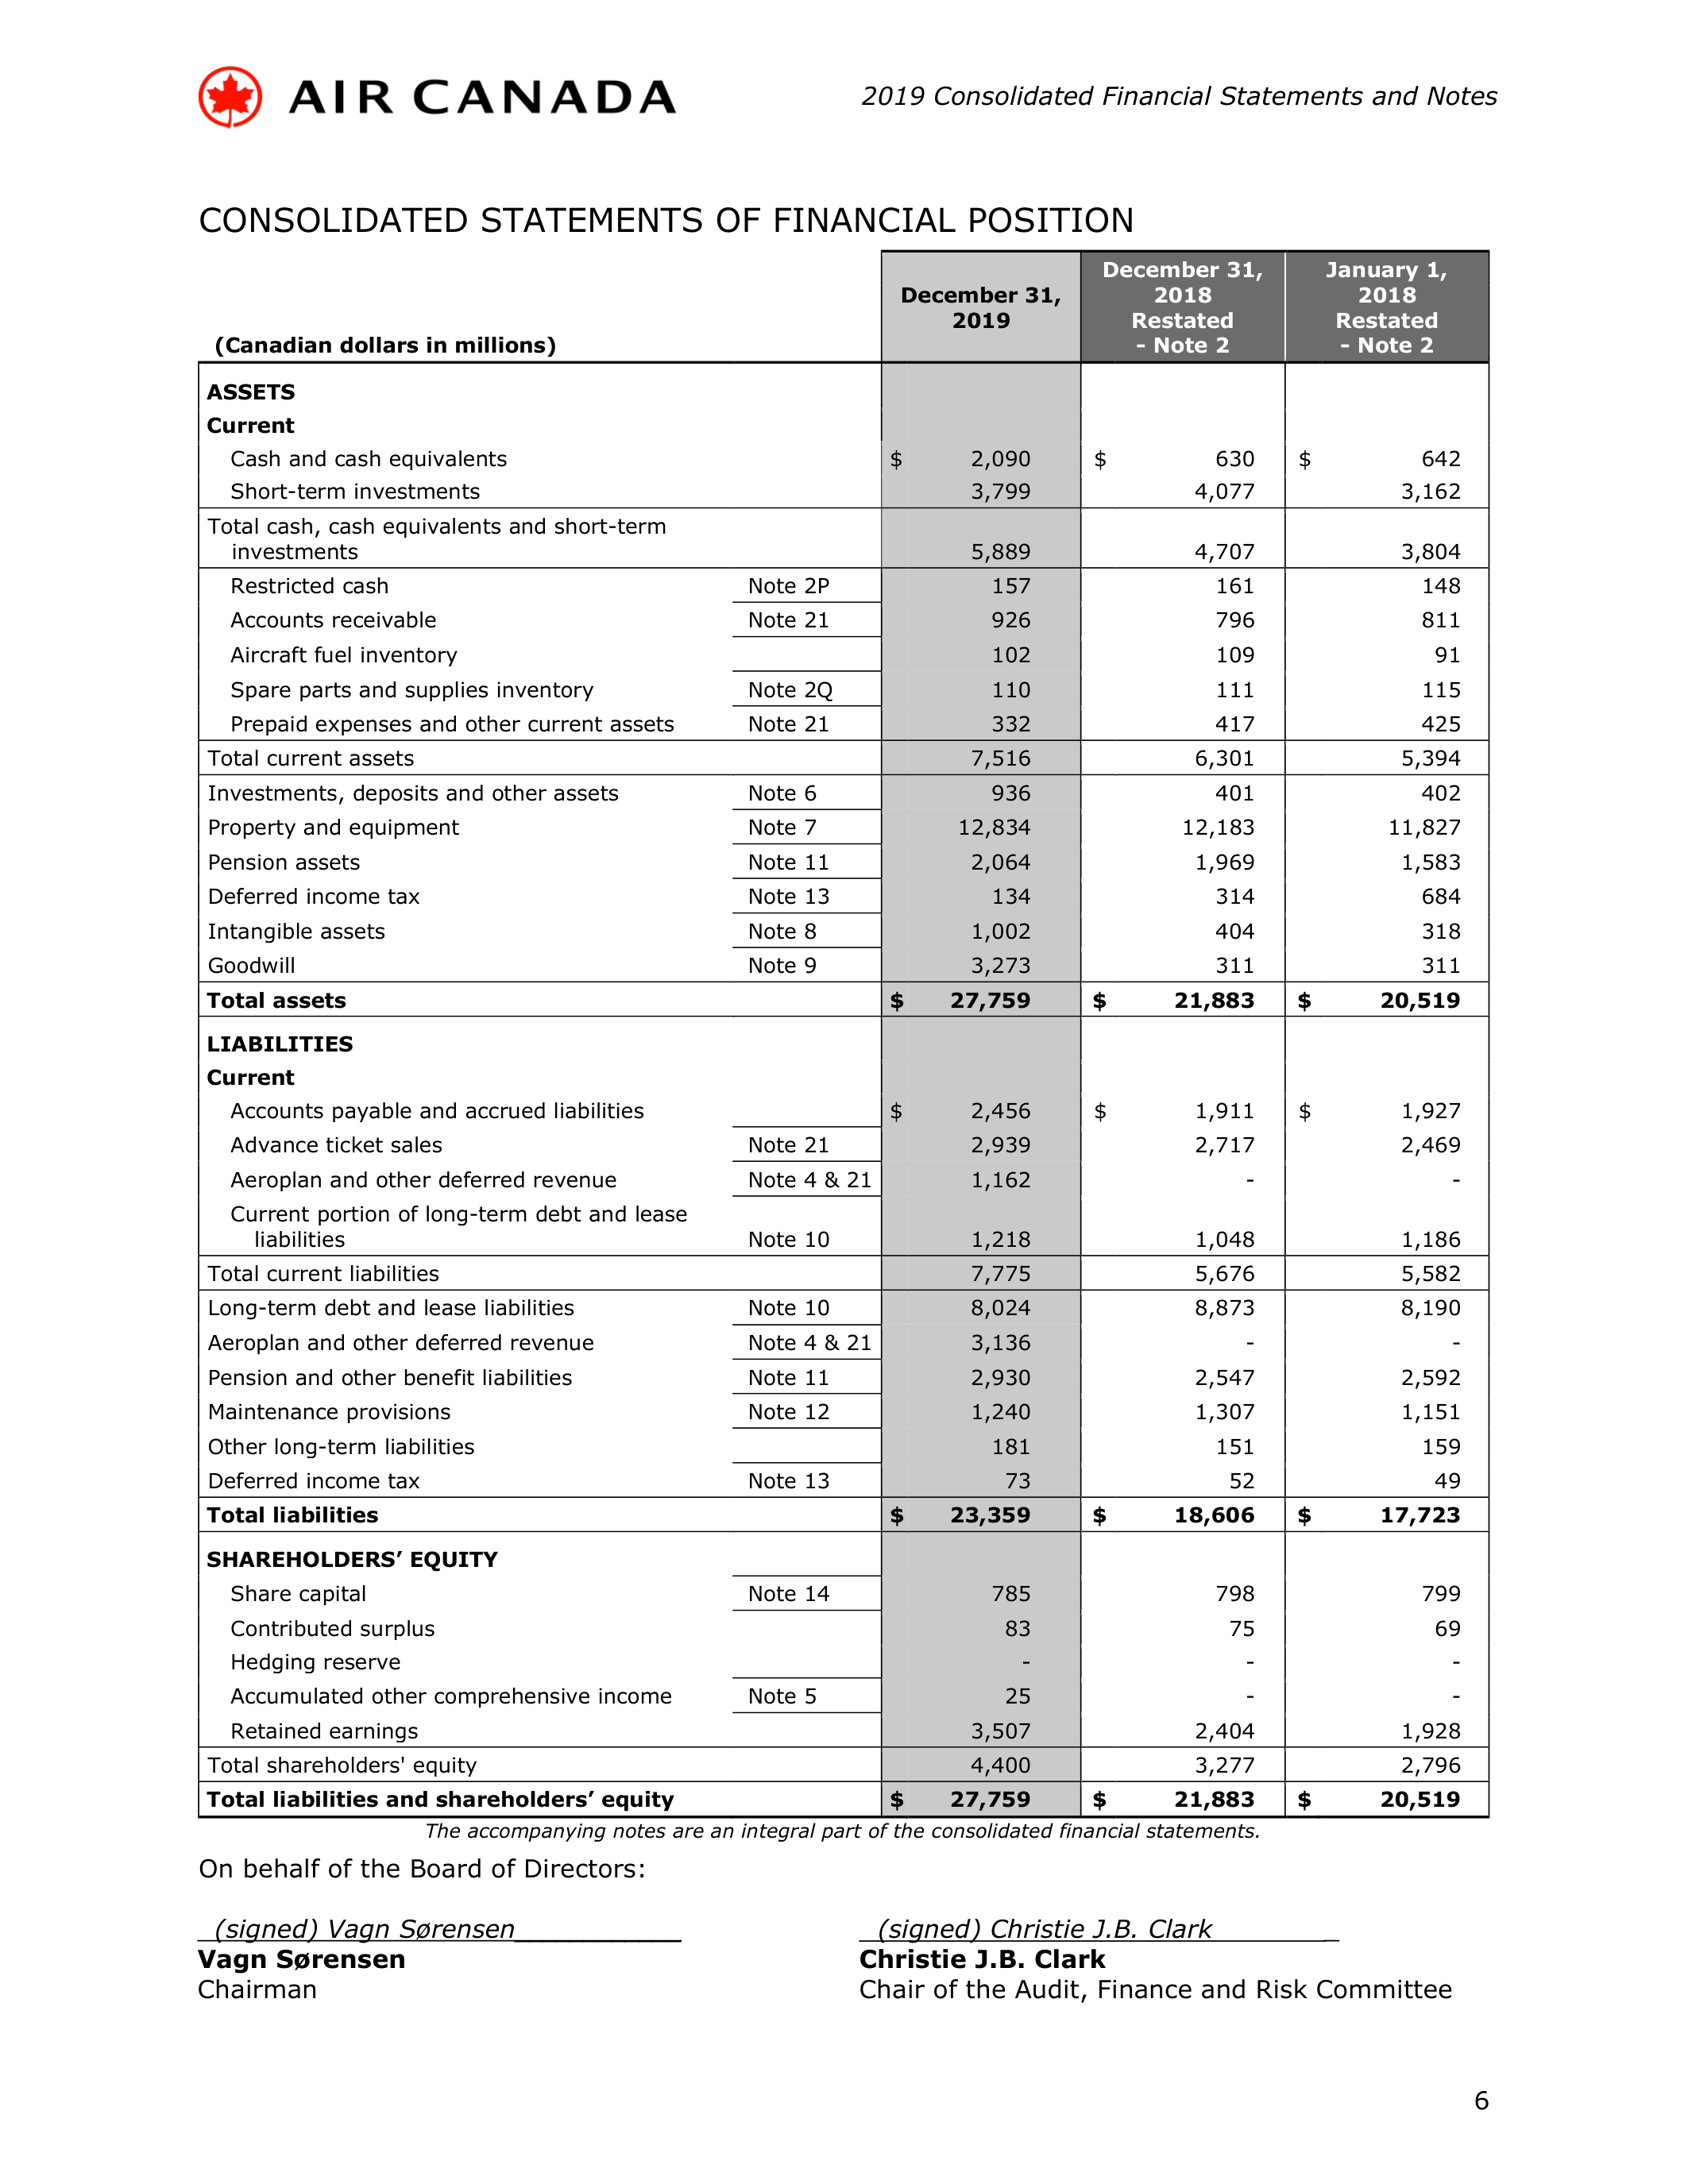

In [18]:
#
# Extract page image from PDF
#

# Convert PDF page to image
page_pixmap = statement_page #s[page_index]
page_image = Image.frombytes("RGB", [page_pixmap.width, page_pixmap.height], page_pixmap.samples)

# Parse image dimensions
page_width = page_pixmap.width
page_height = page_pixmap.height
page_depth = page_pixmap.n
print(f"Image dimensions: {page_width} x {page_height} x {page_depth}")

# Display page image
display(page_image)

## Binarization

In [19]:
# Global adaptive thresholding
# Returns: binarized array
def global_adaptive_thresholding(pixmap):

	# Convert image to array
	image_array = np.frombuffer(pixmap.samples, dtype=np.uint8)
	image_array = image_array.reshape((pixmap.height, pixmap.width, pixmap.n))

	# Convert image to grayscale
	grayscale_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

	# Apply Otsu thresholding
	otsu_threshold, binarized_array = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

	return binarized_array

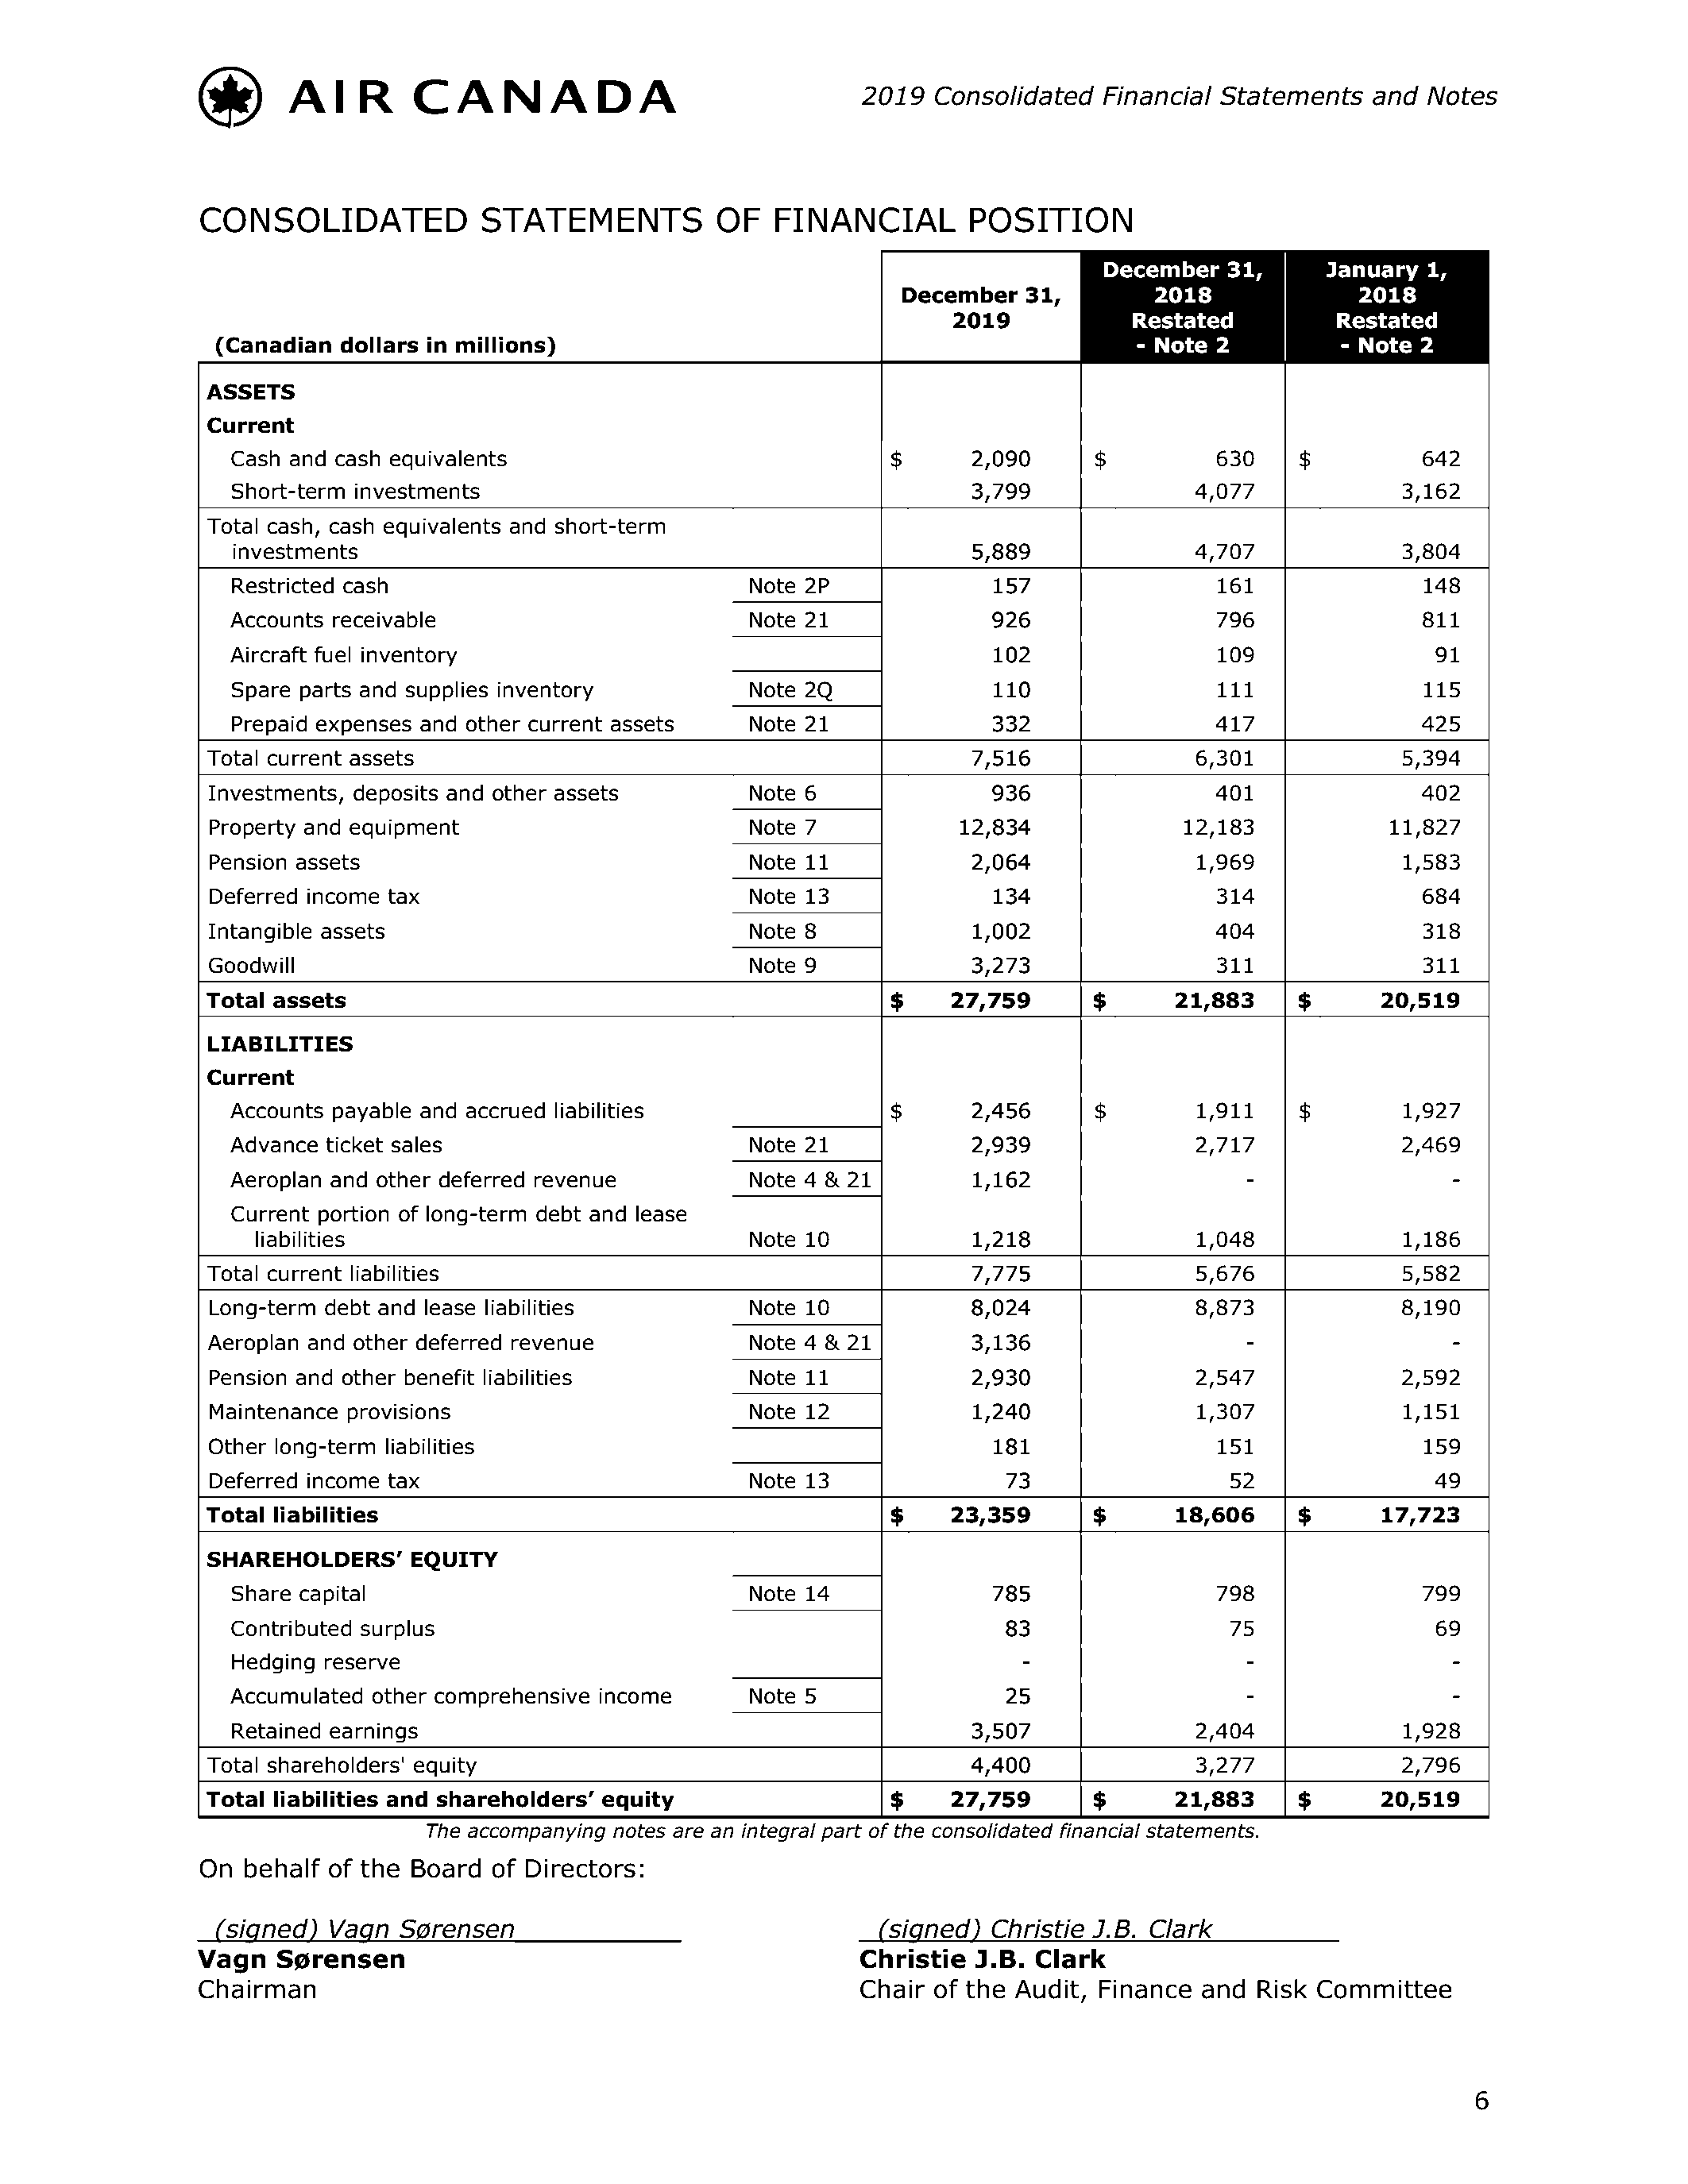

In [20]:
# Binarize image
binarized_array = global_adaptive_thresholding(page_pixmap)

# Display image
binarized_image = Image.fromarray(binarized_array).convert("RGB")
display(binarized_image)

## Table Segmentation

In [21]:
# Instantiate location and structure segmentation models
table_model_location = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
table_model_structure = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

In [22]:
# Instantiate DETR model feature extractor (https://arxiv.org/abs/2005.12872)
image = binarized_image
feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")

# Infer table location and structure
with torch.no_grad():
  tl_outputs = table_model_location(**encoding)
  ts_outputs = table_model_structure(**encoding)

d:\Projects\UoL\Final Project\Prototype\.venv\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [23]:
#
# Function to display an image with bounding boxes overlaid
#
def display_image_boxes(image, boxes):
  COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125], [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
  plt.figure(figsize=(16,10))
  plt.imshow(image)
  ax = plt.gca()
  ax.axis('off')
  colors = COLORS * (len(boxes) // len(COLORS) + 1)
  for (x1, y1, x2, y2), colr in zip(boxes, colors):
  	ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=colr, linewidth=3))

#
# Check if columns are closely adjacent
#
def are_columns_adjacent(box1, box2):
  return abs(box2[2] - box1[0]) < 2 or abs(box1[2] - box2[0]) < 2

#
# Check if bounding box is a column
#
def is_column(box):
  if (box[2]-box[0]) < (box[3]-box[1]):
    return True
  return False

#
# Calculate the bounding box area
#
def box_area(box):
  return (box[2]-box[0]) * (box[3]-box[1])

#
# Check if bounding boxes overlap
#
def boxes_overlap(box1, box2, overlap_ratio=0.4):
  dx = min(box1[2], box2[2]) - max(box1[0], box2[0])
  dy = min(box1[3], box2[3]) - max(box1[1], box2[1])
  area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
  area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
  if (dx >= 0) and (dy >= 0):
    overlap_area = dx * dy
    overlap_ratio1 = overlap_area / area1
    overlap_ratio2 = overlap_area / area2
    if overlap_ratio1 > overlap_ratio or overlap_ratio2 > overlap_ratio:
      return True
  return False

#
# Check if bounding box is in the list
#
def is_box_in_list(box, list):
  return any([all(box==element) for element in [boxel for boxel in list]])

Table location: [255.04727172851562, 317.40789794921875, 1841.121826171875, 2280.587890625]


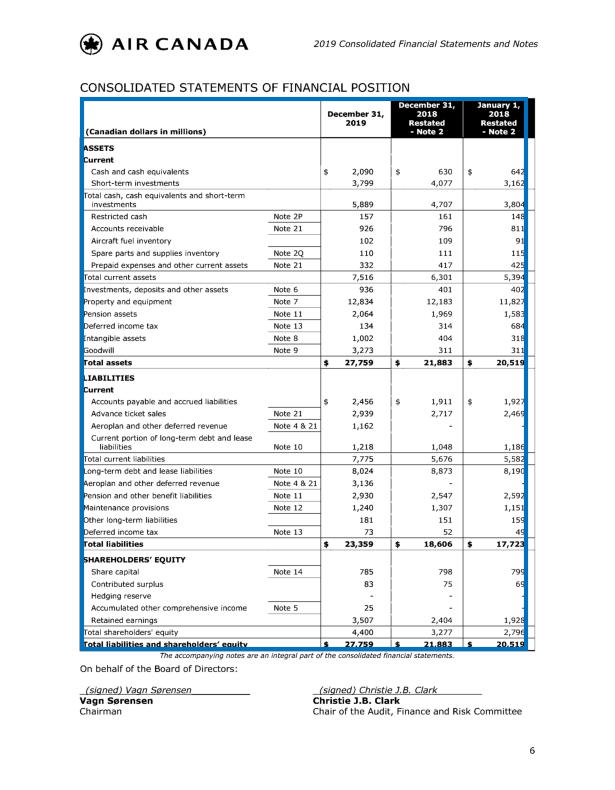

In [24]:
#
# Segment table location
#
width, height = image.size
location_results = feature_extractor.post_process_object_detection(tl_outputs, threshold=0.2, target_sizes=[(height, width)])[0]

# Extract table location
padding = 5
table_location = location_results["boxes"][0].tolist()
table_location = [table_location[0] - padding, table_location[1], table_location[2] + padding, table_location[3]]
print(f"Table location: {table_location}")

# Display segmented table bounding box
display_image_boxes(image, [table_location])

Max column area: 2490999.8657402857
Number of columns: 8


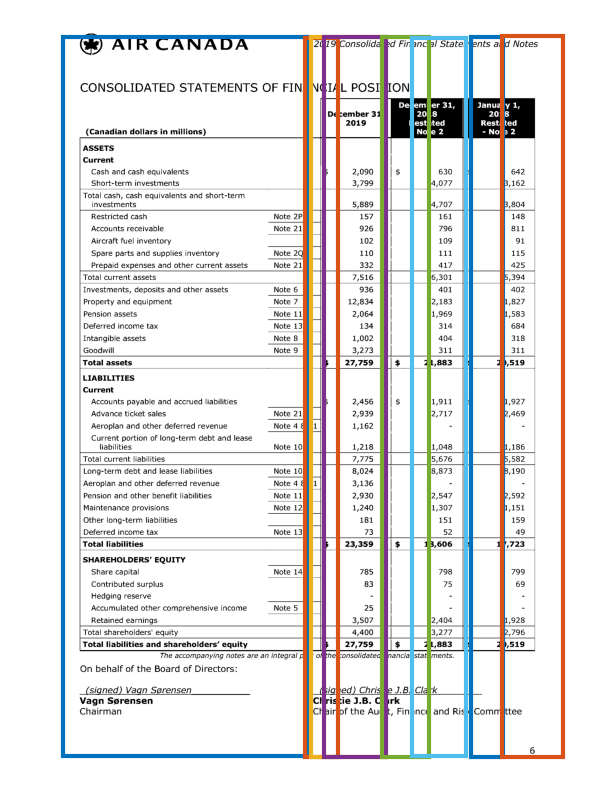

In [25]:
#
# Analyze table structure
#
target_sizes = [image.size[::-1]]
ts_results = feature_extractor.post_process_object_detection(ts_outputs, threshold=0.7, target_sizes=target_sizes)[0]

# Extract only columns
max_column_area = (table_location[2] - table_location[0]) * (table_location[3] - table_location[1]) * 0.8
print(f"Max column area: {max_column_area}")
column_boxes = [box for box in ts_results['boxes'] if is_column(box) and box_area(box)<max_column_area]
num_boxes = len(column_boxes)

# Merge closely adjacent or overlapping columns
merged_columns = []
removed_columns = []
for i, box1 in enumerate(column_boxes):
  for j, box2 in enumerate(column_boxes):
    if i != j:
      # Check if columns adjacent or overlapping
      if are_columns_adjacent(box1, box2) or boxes_overlap(box1, box2):

        # Merge columns
        merged_box = torch.tensor([min(box1[0], box2[0]), min(box1[1], box2[1]), max(box1[2], box2[2]), max(box1[3], box2[3])])
        if not is_box_in_list(merged_box, merged_columns):
          merged_columns.append(merged_box)

        # Mark pieces of merged column for removal
        if not is_box_in_list(box1, removed_columns):
          removed_columns.append(box1)
        if not is_box_in_list(box2, removed_columns):
          removed_columns.append(box2)
      else:
        # Add if not already in merged list
        if not is_box_in_list(box1, merged_columns):
          merged_columns.append(box1)

# Remove discarded columns that were merged
column_boxes = [box for box in merged_columns if not is_box_in_list(box, removed_columns)]
num_boxes = len(column_boxes)
print(f"Number of columns: {num_boxes}")

# Sort columns left to right
column_boxes = sorted(column_boxes, key=lambda box: box[0])

# Display the inferred columns
display_image_boxes(image, column_boxes)

In [26]:
#
# Get line item text
#

# OCR page text
page_pd_ocr = pytesseract.image_to_data(image, output_type="data.frame")
page_pd_ocr.dropna(subset=["text"], inplace=True)
print(f"Page number of fields: {len(page_pd_ocr)}")

# Calculate other position values
page_pd_ocr["right"] = page_pd_ocr["left"] + page_pd_ocr["width"]
page_pd_ocr["bottom"] = page_pd_ocr["top"] + page_pd_ocr["height"]
page_pd_ocr.reset_index(inplace=True)

# Filter first column (fc) elements
fc_box = column_boxes[0]
fc_pd = page_pd_ocr[(page_pd_ocr["right"]) < int(fc_box[2])] # Constrain to first column
fc_pd = fc_pd.dropna(subset=["text"]) # Drop NaN rows
fc_pd = fc_pd[fc_pd["text"].str.isspace() & fc_pd["text"] != ""] # Drop rows that have blank text
fc_pd.reset_index(inplace=True)
print(f"Column number of fields: {len(fc_pd)}")

# Display some of the fields
field_index = 50
page_pd_ocr[field_index:field_index+15]

Page number of fields: 388
Column number of fields: 200


,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,right,bottom
50,118,5,1,21,2,1,9,1711,425,66,20,96.242920,Note,1777,445
51,119,5,1,21,2,1,10,1789,424,15,20,95.973114,2,1804,444
52,121,5,1,21,2,2,1,260,483,111,20,96.202538,ASSETS,371,503
53,123,5,1,21,2,3,1,261,525,109,20,96.107002,Current,370,545
54,126,5,1,21,3,1,1,291,567,61,20,96.767624,Cash,352,587
55,127,5,1,21,3,1,2,365,567,45,20,95.972420,and,410,587
56,128,5,1,21,3,1,3,422,567,56,20,95.972420,cash,478,587
57,129,5,1,21,3,1,4,491,567,147,25,96.347168,equivalents,638,592
58,130,5,1,21,3,1,5,1122,567,13,25,93.068115,$,1135,592
59,131,5,1,21,3,1,6,1224,567,73,25,96.579666,"2,090",1297,592


In [27]:
# Concatenate words and widths
line_item_labels_pd = fc_pd
line_item_labels_pd = fc_pd\
	.groupby(["par_num", "line_num"])\
	.agg({"text": " ".join, "left": "first", "top": "first", "width": "sum", "height": "max"})\
  .reset_index()

# Calculate other fields
line_item_labels_pd["bottom"] = line_item_labels_pd["top"] + line_item_labels_pd["height"]

# Strip non-alphanumeric chars
inter_word_gap = 5
line_item_labels_pd["text"].replace(r"[^0-9a-zA-Z ]+", "", regex=True, inplace=True)

# Drop non-essential columns
line_item_labels_pd.drop(columns=["par_num", "line_num"], inplace=True)

# Compute peak left margins
# histogram, bin_margins = np.histogram(fc_formatted_pd["left"], bins=10)
# top_peak_indices = np.argsort(histogram)[-2:]
# peak_margins = (bin_margins[:-1] + bin_margins[1:]) / 2
# print(np.round(peak_margins[top_peak_indices]))

# Count number of labels
num_item_labels = len(line_item_labels_pd)

line_item_labels_pd.head(8)

,text,left,top,width,height,bottom
0,e AIR CANADA CONSOLIDATED STATEMENTS OF The ...,250,84,2823,1828,1912
1,Vagn Sgrensen,249,2455,245,30,2485
2,Chairman,250,2492,147,25,2517
3,Canadian dollars in millions,272,424,391,25,449
4,ASSETS,260,483,111,20,503
5,Current,261,525,109,20,545
6,Cash and cash equivalents,291,567,309,25,592
7,Shortterm investments,292,608,299,20,628


In [28]:
#
# Extract line elements for the designated column
#
def extract_line_elements(column_box, df_labels, df_page_ocr):

	# Extract first column cells for each line item
	elements = []
	v_tolerance = 12
	num_extracted_values = 0
	for row in df_labels.itertuples():

		# Extract OCR text for cell in this column
		val_pd = df_page_ocr[\
			(df_page_ocr["left"] >= int(column_box[0])) & ((df_page_ocr["right"]) <= int(column_box[2])) & \
			(df_page_ocr["top"] >= int(row.top - v_tolerance)) & ((df_page_ocr["bottom"]) <= int(row.bottom + v_tolerance))
		]

		# Only save value if it's not blank
		if not val_pd.empty:

			# Get the list of values (there can be more than one)
			cell_values = val_pd["text"].values

			# Strip non-value characters from all elements
			cell_values = [re.sub(r"[^0-9(). ]+", "", element) for element in cell_values]

			# Take the first value
			cell_value = cell_values[0]
			if cell_value != "":
				num_extracted_values += 1
		else:
			cell_value = ""

		# Save element data
		element = { "label": row.text, "value": cell_value }
		elements.append(element)


	return elements, num_extracted_values

In [29]:
#
# Extract values for first best column
#

# Get column bounding box
prospective_elements = []
for fc_box in column_boxes:

	# Extract elements
	elements, num_extracted_values = extract_line_elements(fc_box, line_item_labels_pd, page_pd_ocr)
	prospective_elements.append({ "elements": elements, "num_extracted_values": num_extracted_values })

# Prefer the leftmost column with at least half of the values
best_values = None
acceptable_threshold = int(num_item_labels * 0.5)
for elements in prospective_elements:
	if elements["num_extracted_values"] > acceptable_threshold:
		best_values = elements
		break

# Otherwise just use the best column
if best_values == None:
	best_values = sorted(prospective_elements, key=lambda x: x["num_extracted_values"], reverse=True)[0]

# Display the results
print(f"Extracted values: {best_values['num_extracted_values']} of {num_item_labels}")
best_values

Extracted values: 30 of 46


{'elements': [{'label': 'e AIR CANADA CONSOLIDATED STATEMENTS OF   The accompanying notes are an integrai On behalf of the Board of Directors signed Vagn Sgrensen  ',
   'value': '2019'},
  {'label': 'Vagn Sgrensen', 'value': ''},
  {'label': 'Chairman', 'value': ''},
  {'label': 'Canadian dollars in millions', 'value': ''},
  {'label': 'ASSETS', 'value': ''},
  {'label': 'Current', 'value': ''},
  {'label': 'Cash and cash equivalents', 'value': ''},
  {'label': 'Shortterm investments', 'value': '3799'},
  {'label': 'Total cash cash equivalents and shortterm', 'value': ''},
  {'label': 'investments', 'value': '5889'},
  {'label': 'Restricted cash Note 2P', 'value': '157'},
  {'label': 'Accounts receivable Note 21', 'value': '926'},
  {'label': 'Aircraft fuel inventory', 'value': '102'},
  {'label': 'Spare parts and supplies inventory Note 2Q', 'value': '110'},
  {'label': 'Prepaid expenses and other current assets Note 21',
   'value': '332'},
  {'label': 'Total current assets', 'value

In [30]:
#
# Extract first column header
#

# Extract all recognized text in the column
col_heading_pd = page_pd_ocr[(page_pd_ocr["left"] >= int(fc_box[0])) & ((page_pd_ocr["right"]) <= int(fc_box[2]))]
col_heading_pd.reset_index(inplace=True)

# Extract the topmost text
col_heading_pd = col_heading_pd.sort_values("top").head(1)
col_heading = col_heading_pd.text.values[0]
col_heading

'Notes'